# Evaluation of GRN inference methods
## Processing results
### by Jalil Nourisa



# Imports

In [16]:
!cd ../ && bash env.sh 

Base directory set to: /Users/jno24/Documents/projs/ongoing
Wrote env.yaml


In [17]:
# Reload and autoreload settings for modules
%reload_ext autoreload
%autoreload 2

# Import necessary libraries
import os
import pandas as pd
import yaml
import matplotlib.pyplot as plt
import sys
import numpy as np
import json
from scipy.stats import pearsonr
from pandas.api.types import CategoricalDtype
import seaborn
import matplotlib
from matplotlib.gridspec import GridSpec
import warnings
from grn_benchmark.src.helper import load_env
env = load_env()


# Suppress warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

# Set plot parameters
plt.rcParams['font.family'] = 'Arial'  # Arial or 'Liberation Sans'
default_font = matplotlib.rcParams['font.family']
print(default_font)

# Add the src folder to the path
GRN_BENCHMARK_DIR = env['GRN_BENCHMARK_DIR']
sys.path.insert(0, GRN_BENCHMARK_DIR)
from src.helper import surrogate_names, colors_blind, palette_celltype, palette_methods, \
        DATASETS, plot_heatmap, \
        read_yaml

TASK_GRN_INFERENCE_DIR = env['TASK_GRN_INFERENCE_DIR']
sys.path.insert(0, TASK_GRN_INFERENCE_DIR)
from src.utils.config import METHODS, METRICS, FINAL_METRICS

# Set paths for task grn inference

RESULTS_DIR = f'{TASK_GRN_INFERENCE_DIR}/resources/results'
scores_dir = f'{RESULTS_DIR}/'
models = ['celloracle', 'grnboost', 'pearson_corr', 'positive_control', 'negative_control',
            'scenicplus','granie','figr','scglue','scenic','ppcor', 'portia', 'spearman_corr', 'scgpt', 'geneformer']

%matplotlib inline

['Arial']


In [18]:
def plot_raw_scores(scores, ax):
    scores_dir = scores.set_index('model').drop(columns='dataset')
    scores = scores.dropna(how='all', axis=1)
    
    scores = scores[[c for c in METRICS if c in scores.columns]]
    scores.columns = scores.columns.map(lambda name: surrogate_names.get(name, name))
    scores.index = scores.index.map(lambda name: surrogate_names.get(name, name))
    scores = scores.astype(float)
    ranks = scores.rank(axis=0, ascending=False, method='min')
    scores['_overall_rank'] = ranks.mean(axis=1, skipna=True)
    scores = scores.sort_values(by='_overall_rank').drop(columns=['_overall_rank'])
    plot_heatmap(scores, name='', ax=ax, cmap="viridis")
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right')
    ax.set_ylabel('')
    return scores_mat.index
def process_trace_func(trace):
    cols = ['%cpu', 'peak_rss', 'peak_vmem', 'rchar', 'wchar']
    datasets = DATASETS
    t_store = []
    for model in METHODS:
        for i, row in trace.iterrows():
            if f'{model}_process' in row['name']:
                t = trace.loc[[i], cols]
                t['model'] = model

                for dataset in datasets:
                    if dataset in row['name']:
                        t['dataset'] = dataset
                        t_store.append(t)
                        break
    if len(t_store) == 0:
        print("trace file has not model process info -> skipping processing")
        return pd.DataFrame()
    trace_df = pd.concat(t_store).reset_index()
    if True:
        # Conversion factors
        unit_to_bytes = {
            "KB": 1024,
            "MB": 1024**2,
            "GB": 1024**3,
            "B": 1
        }

        def convert_to_gb(value):
            if pd.isna(value):
                return None
            value = str(value).strip()
            try:
                num, unit = value.split()
                num = float(num)
                unit = unit.upper()
                if unit in unit_to_bytes:
                    return num * unit_to_bytes[unit] / (1024**3)  # convert bytes → GB
                else:
                    return float(num)  # fallback if no unit
            except Exception:
                return None

        # - remove GB and MB from the columns
        # Apply conversion
        for col in ["peak_rss", "peak_vmem", "rchar", "wchar"]:
            trace_df[col] = trace_df[col].apply(convert_to_gb)

        # Rename columns with consistent units
        for col in ["%cpu"]:
            trace_df[col] = trace_df[col].str.replace(r"[^0-9.]", "", regex=True).astype(float)

        trace_df.rename(
            columns={
                "%cpu": "CPU Usage (%)",
                "peak_rss": "Peak RSS (GB)",
                "peak_vmem": "Peak VMem (GB)",
                "rchar": "Read Chars (GB)",
                "wchar": "Written Chars (GB)"
            },
            inplace=True
        )
        trace_df = trace_df.round(2)
    
    return trace_df

# Runs: AWS

GRN inference and evaluation are two seperate pipelines. Download and install https://github.com/openproblems-bio/task_grn_inference, then:
Inside `scripts/run_all.sh`, select the relevant step. GRN inference is very computational intensive.

In [ ]:
for dataset in DATASETS:
    !aws s3 sync s3://openproblems-data/resources/grn/results/$dataset {RESULTS_DIR}/$dataset --exclude "*" --include "*.yaml" --include "*.txt" --include "*.csv"

download: s3://openproblems-data/resources/grn/results/op/trace_merged.txt to ../../task_grn_inference/resources/results/op/trace_merged.txt
download: s3://openproblems-data/resources/grn/results/parsebioscience/trace_merged.txt to ../../task_grn_inference/resources/results/parsebioscience/trace_merged.txt
download: s3://openproblems-data/resources/grn/results/parsebioscience/trace_merged.txt to ../../task_grn_inference/resources/results/parsebioscience/trace_merged.txt
download: s3://openproblems-data/resources/grn/results/300BCG/trace_merged.txt to ../../task_grn_inference/resources/results/300BCG/trace_merged.txt
download: s3://openproblems-data/resources/grn/results/300BCG/trace_merged.txt to ../../task_grn_inference/resources/results/300BCG/trace_merged.txt
download: s3://openproblems-data/resources/grn/results/ibd_uc/trace_merged.txt to ../../task_grn_inference/resources/results/ibd_uc/trace_merged.txt
download: s3://openproblems-data/resources/grn/results/ibd_uc/trace_merged.txt

In [ ]:
# - this code assembles indivudual runs for final results
# !python {TASK_GRN_INFERENCE_DIR}/src/process_data/process_trace_files.py --input_base {RESULTS_DIR}

# Runs: local

In [2]:
# !cd {TASK_GRN_INFERENCE_DIR} && bash scripts/local_workflows/run_grn_inference.sh 
# !cd {TASK_GRN_INFERENCE_DIR} && bash scripts/local_workflows/run_grn_evaluation.sh --run_consensus --run_metrics 
# !cd {TASK_GRN_INFERENCE_DIR} && bash scripts/local_workflows/run_grn_evaluation.sh --process_results 

# Metrics applicability

In [35]:
output_dir = f"{RESULTS_DIR}/experiment/metrics_applicibility"
!cd ../ && python src/stability_analysis/metrics_applicibility/script.py --cv_threshold 0.2 --output {output_dir} --local_run


Results saved to: /Users/jno24/Documents/projs/ongoing/task_grn_inference/resources/results/experiment/metrics_applicibility
Metrics summary saved to: /Users/jno24/Documents/projs/ongoing/task_grn_inference/resources/results/experiment/metrics_kept_per_dataset.yaml
                 Total  Keep      Keep %
dataset                                 
ibd_cd               5     5  100.000000
ibd_uc               5     5  100.000000
op                   7     7  100.000000
parsebioscience      7     7  100.000000
300BCG               7     6   85.714286
norman               7     6   85.714286
replogle            10     8   80.000000
xaira_HCT116        10     7   70.000000
nakatake             5     3   60.000000
xaira_HEK293T       10     6   60.000000

                  Metric                                                                                                                                             Summary                                                                    

# Scores datasets

/Users/jno24/Documents/projs/ongoing/task_grn_inference/resources/results/figs/raw_scores/
Saving figure to: /Users/jno24/Documents/projs/ongoing/task_grn_inference/resources/results/figs/raw_scores//raw_scores_op.png
Saving figure to: /Users/jno24/Documents/projs/ongoing/task_grn_inference/resources/results/figs/raw_scores//raw_scores_parsebioscience.png
Saving figure to: /Users/jno24/Documents/projs/ongoing/task_grn_inference/resources/results/figs/raw_scores//raw_scores_300BCG.png
Saving figure to: /Users/jno24/Documents/projs/ongoing/task_grn_inference/resources/results/figs/raw_scores//raw_scores_ibd_uc.png
Saving figure to: /Users/jno24/Documents/projs/ongoing/task_grn_inference/resources/results/figs/raw_scores//raw_scores_ibd_cd.png
Saving figure to: /Users/jno24/Documents/projs/ongoing/task_grn_inference/resources/results/figs/raw_scores//raw_scores_replogle.png
Saving figure to: /Users/jno24/Documents/projs/ongoing/task_grn_inference/resources/results/figs/raw_scores//raw_sco

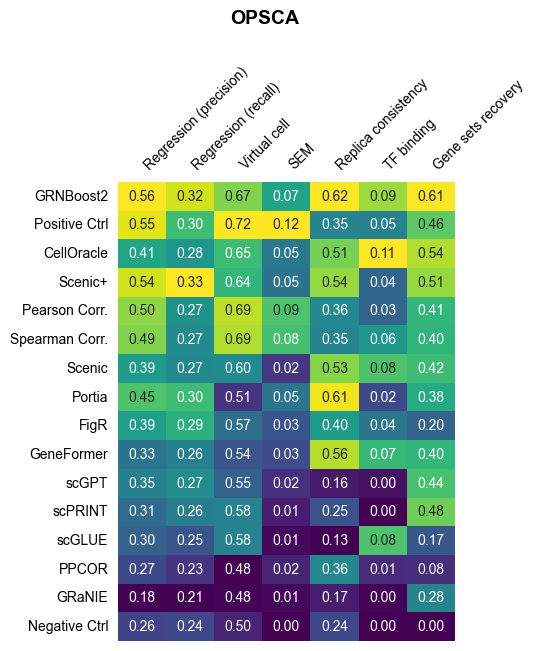

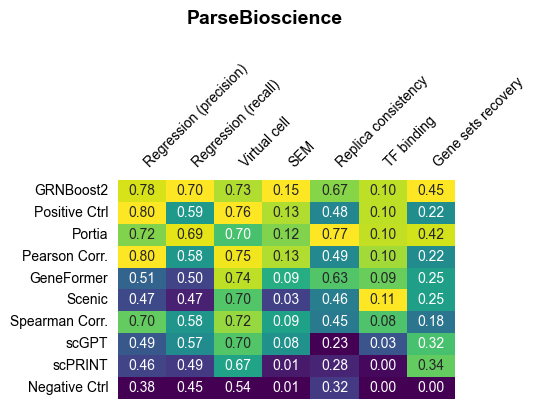

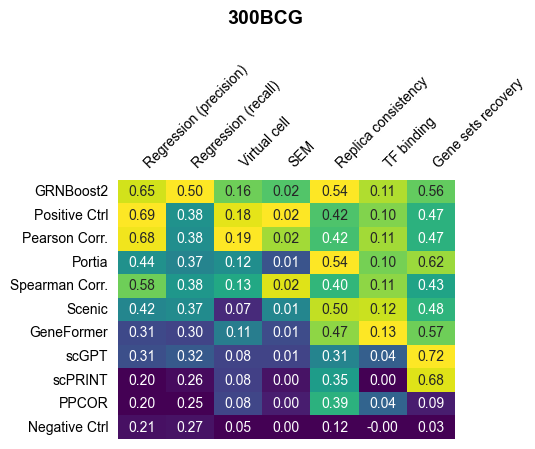

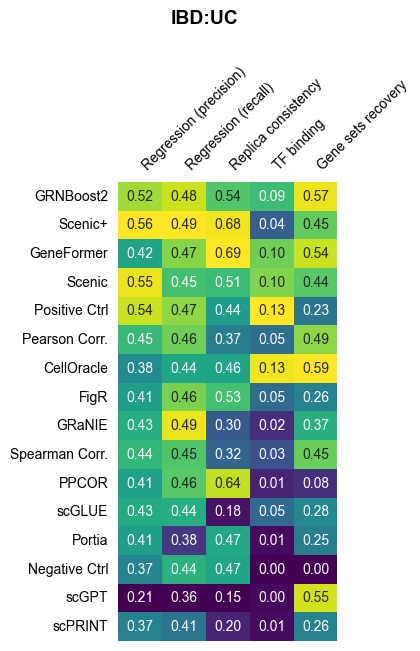

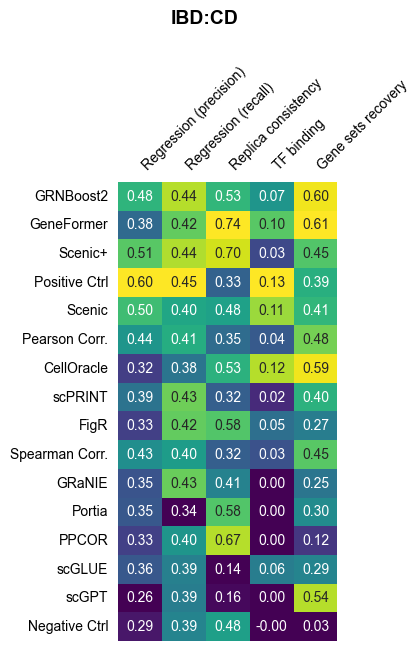

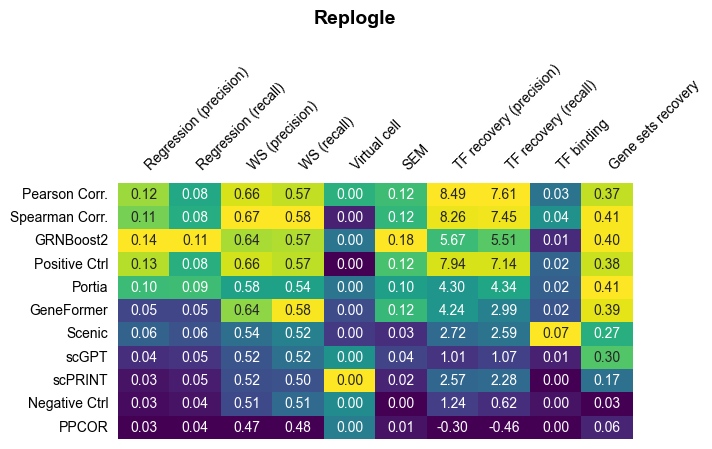

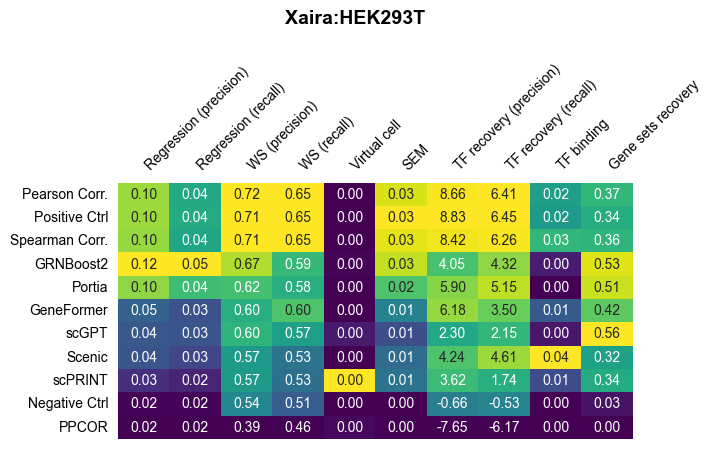

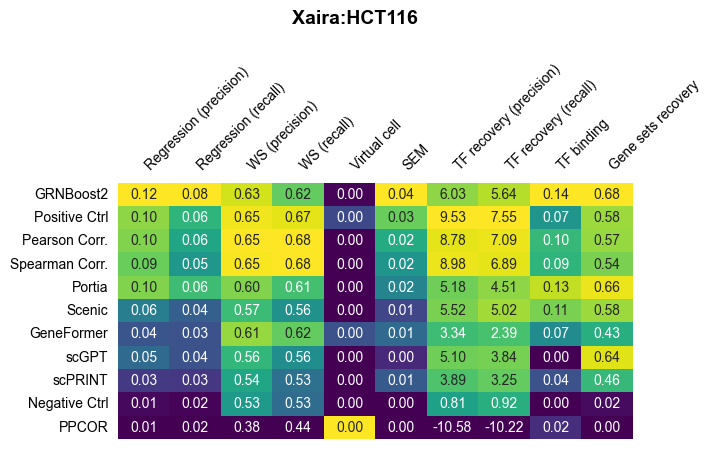

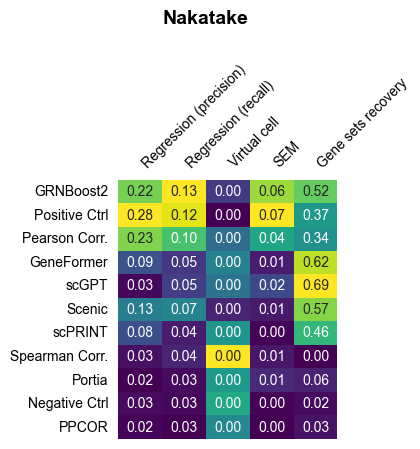

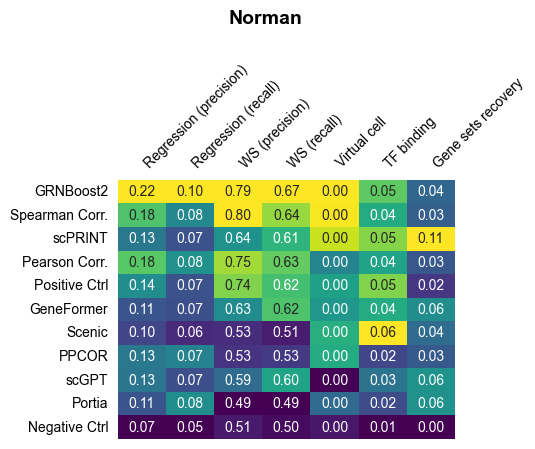

In [45]:
local_run = True
process_trace = False
datasets = DATASETS

if local_run:
    scores_all = pd.read_csv(f"{TASK_GRN_INFERENCE_DIR}/resources/results/all_scores.csv")
    scores_all = scores_all[METRICS + ['method', 'dataset']]
    scores_all.rename(columns={'method': 'model'}, inplace=True)
else:
    from src.helper import read_yaml
    
    scores_store = []
    trace_df_store = []
    for dataset in datasets: 
        scores_file = f"{TASK_GRN_INFERENCE_DIR}/resources/results/{dataset}/score_uns.yaml"
        if os.path.exists(scores_file):
            print(dataset)
            df = read_yaml(scores_file)
            df.fillna(0, inplace=True)
            scores_store.append(df)
        if process_trace:
            trace = pd.read_csv(f"{TASK_GRN_INFERENCE_DIR}/resources/results/{dataset}/trace_merged.txt", sep='\t')
            trace = process_trace_func(trace)
            trace_df_store.append(trace)
    scores_all = pd.concat(scores_store)
    scores_all.columns.name = ''
    if process_trace:
        trace_all = pd.concat(trace_df_store)
        if 'task_id' in trace_all.columns:
            trace_all = trace_all.drop(columns=['task_id'])
        if len(trace_all)>0:
            trace_all.index.name = ''
            trace_all.drop('index', axis=1, inplace=True)
        # assert scores_all['model'].unique().tolist() == trace_all['model'].unique().tolist(), "Trace data does not match expected models"
    
    scores_all = scores_all[scores_all['model'].isin(METHODS)]
raw_scores_dir = f"{RESULTS_DIR}/figs/raw_scores/"
os.makedirs(raw_scores_dir, exist_ok=True)
print(raw_scores_dir)
if True:
    for dataset in datasets: 
        scores = scores_all[scores_all['dataset'] == dataset]
        scores = scores.loc[:, ~scores.isna().all()]
        
        n_rows = scores.shape[0]
        n_cols = scores.shape[1]
        if process_trace:
            figsize = (n_cols * 0.4, max(n_rows * 0.4, 4))
            fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=False, width_ratios=[1, 0.9])
        else:
            figsize = (n_cols * 0.6, max(n_rows * 0.4, 4))
            fig, axes = plt.subplots(1, 1, figsize=figsize, sharey=False)
        
        if True:
            ax = axes[0] if process_trace else axes
            scores = scores.set_index('model').drop(columns='dataset')
            scores = scores.dropna(how='all', axis=1)
            scores = scores[[c for c in METRICS if c in scores.columns]]
            scores.columns = scores.columns.map(lambda name: surrogate_names.get(name, name))
            scores.index = scores.index.map(lambda name: surrogate_names.get(name, name))
            scores = scores.astype(float)
            ranks = scores.rank(axis=0, ascending=False, method='min')
            scores['_overall_rank'] = ranks.mean(axis=1, skipna=True)
            scores = scores.sort_values(by='_overall_rank').drop(columns=['_overall_rank'])
            plot_heatmap(scores, name='', ax=ax, cmap="viridis")
            ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right')
            ax.set_ylabel('')
            ordered_methods = scores.index
        
        if process_trace:
            traces = trace_all[trace_all['dataset'] == dataset]
            ax = axes[1]
            trace = traces
            
            trace = trace.set_index('model').drop(columns='dataset')
            trace.index = trace.index.map(lambda name: surrogate_names.get(name, name))
            trace = trace.dropna(how='all', axis=1)
            trace = trace.loc[[c for c in ordered_methods if c in trace.index]]
            plot_heatmap(trace, name='', ax=ax, cmap="viridis")
            ax.set_ylabel('')
        
        plt.suptitle(surrogate_names.get(dataset, dataset), y=1.01, fontsize=14, weight='bold')
        plt.tight_layout()
        file_name = f"{raw_scores_dir}/raw_scores_{dataset}.png"
        print("Saving figure to:", file_name)
        fig.savefig(file_name, dpi=200, transparent=True, bbox_inches='tight')
        fig.savefig(f"{TASK_GRN_INFERENCE_DIR}/docs/source/images/raw_scores_{dataset}.png", dpi=100, transparent=True, bbox_inches='tight')

# Overview of performance

In [34]:
if local_run:
    !cd ../ && python scripts/combine_results.py --local_run
else:
    !cd ../ && python scripts/combine_results.py

Processing 10 datasets: ['op', 'parsebioscience', '300BCG', 'ibd_uc', 'ibd_cd', 'replogle', 'xaira_HEK293T', 'xaira_HCT116', 'nakatake', 'norman']

1. Copying trace_merged.txt file (using only 'op' dataset)...
  Reading trace from op...
  Saved trace to /Users/jno24/Documents/projs/ongoing/task_grn_inference/resources/results/all_new/trace.csv
  Total unique entries: 271

2. Combining score files...
  Using local run mode - copying all_scores.csv...
  Copying scores from /Users/jno24/Documents/projs/ongoing/task_grn_inference/resources/results/all_scores.csv...
  Saved combined scores to /Users/jno24/Documents/projs/ongoing/task_grn_inference/resources/results/all_new/all_scores.csv

3. Combining dataset_uns.yaml files...
  Reading dataset info from op...
  Reading dataset info from parsebioscience...
  Reading dataset info from 300BCG...
  Reading dataset info from ibd_uc...
  Reading dataset info from ibd_cd...
  Reading dataset info from replogle...
  Reading dataset info from xaira

In [42]:
!cd ../ && python scripts/create_overview_figure.py

Creating Overview Figure

Using base directory: /Users/jno24/Documents/projs/ongoing/task_grn_inference
Results folder: /Users/jno24/Documents/projs/ongoing/task_grn_inference/resources/results
Combined directory: /Users/jno24/Documents/projs/ongoing/task_grn_inference/resources/results/all_new

1. Processing trace data (op dataset only)...
   Total trace entries: 271
   positive_control: duration=0.04h, memory=11.0GB, cpu=283.9%
   pearson_corr: duration=0.04h, memory=13.2GB, cpu=1231.2%
   grnboost: duration=6.67h, memory=28.9GB, cpu=2102.6%
   ppcor: duration=5.72h, memory=25.8GB, cpu=100.1%
   portia: duration=2.96h, memory=28.9GB, cpu=188.9%
   scenic: duration=6.54h, memory=101.1GB, cpu=1991.0%
   geneformer: duration=0.24h, memory=221.7GB, cpu=102.5%
   scgpt: duration=0.10h, memory=5.7GB, cpu=101.4%
   ppcor: duration=5.72h, memory=25.8GB, cpu=100.1%
   scenicplus: duration=16.03h, memory=775.9GB, cpu=961.4%
   celloracle: duration=5.76h, memory=25.3GB, cpu=2404.8%
   figr: dur